- hypothesis around the work
#### _H0: Neighborhood clustering does not reveal significant differences in average Urban Heat Exposure Index across Paris neighborhoods._
#### _H1: Neighborhood clustering reveals distinct groups with significantly different average Urban Heat Exposure Index values, allowing identification of hotter and cooler neighborhoods._

##### Menu
- 0 _["Import Libraries"](#0---import-all-libraries-we-need)_
- 1 _["Data loading & Preprocessing"](#1--data-loading--preprocessing)_
- 2 _["PCA - Variance Analysis"](#2---pca-variance-analysis)_
- 3 _["PCA - Correlation Circles"](#3---pca-correlation-circles)_
- 4 _["PCA - Component Distribution Analysis"](#4---pca-component-distribution-analysis)_
- 5 _["Kmeans - Evaluation (Silhoutte & Inertia)"](#5---k-means-evaluation-silhouette--inertia)_
- 6 _["Kmeans - Final Clustering"](#6---k-means-final-clustering)_
- 7 _["Kmeans - Visualisations in PCA Space"](#7---k-means-visualization-in-pca-space)_
- 8 _["Kmeans - Aggregation At Neighborhood Level"](#8---k-means-aggregation-at-neighborhood-level)_
- 9 _["Kmeans - Spacial Visualisation"](#9---k-means-spatial-visualization)_
- 10 _["DBScan - Clustering (alternative model)"](#10---dbscan-clustering---alternative-model)_
- 11 _["GMM - Gaussian Mixture Model clustering (alternative model)"](#11---gmm-gaussian-mixture-model-clustering---alternative-model)_
- 12 _["GMM - Visualisations in PCA Space"](#12---gmm-visualization-in-pca-space-alternative-model)_
- 13 _["Best Compromise Model"](#13---confirm-which-model--has-best-compromise-between-interpretability-stability-and-spatial-coherence)_

## 0 - import all libraries we need

In [1]:
import pandas as pd
from shapely import geometry
import json
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import geopandas as gpd
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.mixture import GaussianMixture
import requests

## 1- Data loading & preprocessing

In [2]:
# Load the final dataset and prepare features for analysis.
# This step includes reading the CSV file, removing non-numerical identifiers,
# and standardizing all numerical variables to ensure comparable scales
# for PCA and clustering algorithms.

In [3]:
# load the csv file
df=pd.read_csv("Data/data_final.csv",header=0, index_col=0)
df = df.dropna()
df.describe()

,jointure_nhd_id,temp_mean,temp_max,apparent_temp_mean,apparent_temp_max,humidity_mean,wind_speed_mean,cloud_cover_mean,rain_sum,precipitation_sum,...,pub_inst_bar_cafe,pub_inst_hotels_tourism,pub_inst_clothing,pub_inst_bodycare,pub_inst_medical,pub_inst_banks_insurance,pub_inst_electronics,pub_inst_culture_leisure,pub_inst_total_count,pub_inst_total_density
count,4.467600e+04,44676.000000,44676.000000,44676.000000,44676.000000,44676.000000,44676.000000,44676.000000,44676.000000,44676.000000,...,44676.000000,44676.000000,44676.000000,44676.000000,44676.0,44676.000000,44676.000000,44676.000000,44676.000000,44676.000000
mean,7.500000e+08,18.171135,22.943080,17.410183,22.296079,70.475923,11.328830,57.994483,2.658734,2.658734,...,26.150685,21.712329,55.698630,67.575342,0.0,21.301370,15.273973,22.616438,1264.438380,1479.529589
std,2.251128e+01,3.685192,4.498930,4.700054,5.643144,10.310043,4.278108,26.824750,5.102930,5.102930,...,20.900304,15.061213,43.858195,42.464938,0.0,12.609862,15.660316,14.220182,578.228773,1021.775929
min,7.500000e+08,8.052667,10.526000,4.061406,7.745131,31.201095,3.724480,0.000000,0.000000,0.000000,...,2.000000,1.000000,1.000000,2.000000,0.0,1.000000,0.000000,2.000000,258.378252,152.570000
25%,7.500000e+08,15.797937,19.875502,14.470137,18.435120,64.382587,8.096207,41.083333,0.000000,0.000000,...,10.000000,10.000000,20.000000,29.000000,0.0,11.000000,4.000000,12.000000,872.282280,683.080000
50%,7.500000e+08,18.283750,22.658500,17.450829,22.078188,71.629907,10.545961,61.250000,0.300000,0.300000,...,22.000000,16.000000,45.000000,61.000000,0.0,19.000000,12.000000,19.000000,1301.422028,1238.240000
75%,7.500001e+08,20.688333,25.887000,20.997289,26.329745,77.784675,13.774846,79.208333,3.100000,3.100000,...,37.000000,29.000000,76.000000,98.000000,0.0,30.000000,23.000000,31.000000,1597.609035,2092.650000
max,7.500001e+08,30.758834,39.339000,30.212783,39.290783,93.932476,32.454253,100.000000,50.900000,50.900000,...,104.000000,63.000000,178.000000,188.000000,0.0,63.000000,78.000000,68.000000,3460.653715,4289.530000


In [4]:
# check if the call succeed, if the url is correct
def call_status_code_func(base_api_url:str, dataset_name:str)->int:
    url_call_test = f"{base_api_url}/{dataset_name}/records"
    result = requests.get(url_call_test)
    return result.status_code
# count the numbers of rows, the dataset contains
def total_count_func(base_api_url:str, dataset_name:str)->int:
    url_call_test = f"{base_api_url}/{dataset_name}/records"
    result =  requests.get(url_call_test).json().get("total_count")
    return result

# return a list of data
def get_data_func(base_api_url:str, dataset_name:str, column_to_select:list, limit:int=100, offset:int=0)->list|None:
    result = None
    # prepare url format
    column_string_format= ",".join(column_to_select)

    # test the call first
    status_code = call_status_code_func(base_api_url, dataset_name)
    if status_code == 200:
        total_count = total_count_func(base_api_url, dataset_name)
        result = []
        while offset < total_count:
            # build complete url
            final_url= f"{base_api_url}/{dataset_name}/records?select={column_string_format}&limit={limit}&offset={offset}"
            data_results = requests.get(final_url).json().get("results")
            if not data_results:
                break
            result.extend(data_results)
            offset += limit

        print("data extraction succeeded")
        return result
    
    else : 
        print("test call failed, pls check url")
        return result

# tranform the df into geodatafram
def df_with_geometry_polygone_into_geodataframe(df:pd.DataFrame)->gpd.GeoDataFrame:
    gdf_result = gpd.GeoDataFrame(
        df,
        geometry='geometry',
        crs="EPSG:4326"
    )
    return gdf_result

In [5]:
# import neighborhood dataset
# assign the url destination
base_api_url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets"
dataset_name= "quartier_paris"
column_to_select= ["n_sq_qu","c_qu","c_quinsee","l_qu","c_ar", "n_sq_ar" , "surface", "geom_x_y", "geom"]

In [6]:
result = get_data_func(base_api_url,dataset_name, column_to_select)
total_rows = total_count_func(base_api_url, dataset_name)
if len(result) == total_rows:
    print("---we got all data----")
    print("extracted:", len(result))
    print( "DB count:", total_rows)
else:
    print("the dataset contains:", total_rows)
    print("but we got," , len(result))
    print("pls, check the call and result")

data extraction succeeded
---we got all data----
extracted: 80
DB count: 80


In [7]:
# convert data into df 
quartiers_geojson = pd.json_normalize(result)
# quartiers_geojson = gpd.read_file("data/quartier_paris.geojson")
quartiers_geojson['n_sq_qu'] = quartiers_geojson['n_sq_qu'].astype('int64')
# step 1 add geometry column into dataframe
quartiers_geojson['geometry'] = quartiers_geojson['geom.geometry.coordinates'].apply(lambda coords: geometry.Polygon(coords[0]))
# step 2 transform the column into geometry polygon
quartiers_geojson = df_with_geometry_polygone_into_geodataframe(quartiers_geojson)

In [8]:
# Normilize to  scale all variable, better for comapraison
X = StandardScaler().fit_transform(df.drop(columns=['jointure_nhd_id']))



## 2 - PCA variance analysis

In [9]:
# Perform PCA without dimensionality reduction in order to analyze
# the explained variance of all principal components.
# This cell helps determine how many components are required
# to retain most of the information in the dataset.

In [10]:
# fit and transform a variable with two compoenent , for vusalisation only
pca_2_component = PCA(n_components=2)
X_pca = pca_2_component.fit_transform(X)

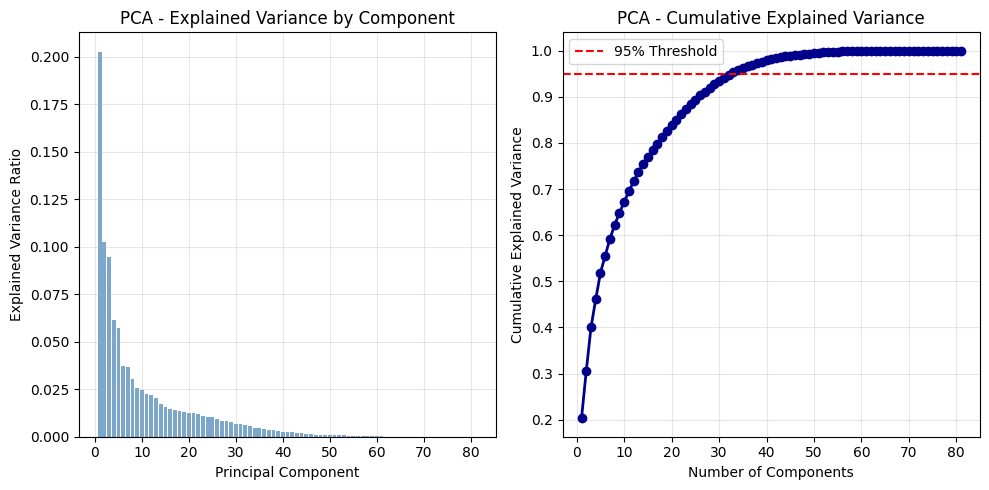

In [11]:
pca_all = PCA()
C = pca_all.fit(X).transform(X)

# Calculate cumulative explained variance
cumsum = np.cumsum(pca_all.explained_variance_ratio_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: Individual explained variance
ax1.bar(range(1, len(pca_all.explained_variance_ratio_) + 1), 
        pca_all.explained_variance_ratio_, alpha=0.7, color='steelblue')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('PCA - Explained Variance by Component')
ax1.grid(alpha=0.3)

# Plot 2: Cumulative explained variance
ax2.plot(range(1, len(cumsum) + 1), cumsum, 'o-', linewidth=2, color='darkblue')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('PCA - Cumulative Explained Variance')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

- PCA was first used to analyze data structure and determine that approximately 35 components were required to explain 95% of the variance.
A PCA projection was then used for visualization.

## 3 - PCA correlation circles

In [12]:
# Visualize the contribution and correlation of original variables
# with components using correlation circles.
# Variables are split into groups for readability.

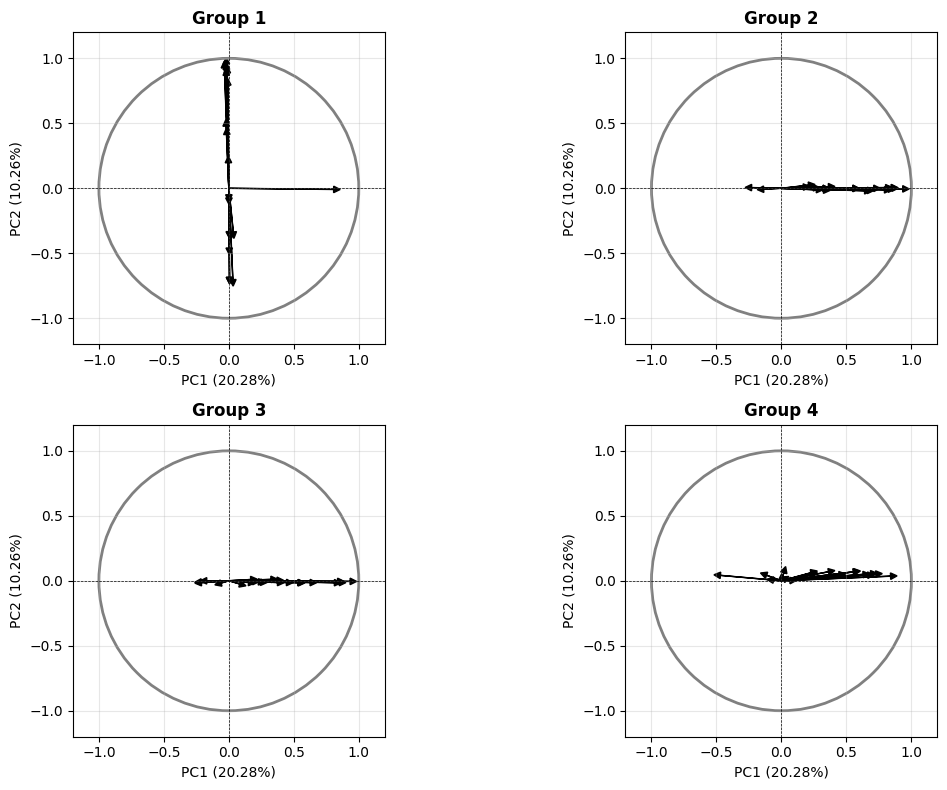

In [13]:
# Create 4 subplots - correlation circles for different variable groups
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

coord1 = pca_all.components_[0] * np.sqrt(pca_all.explained_variance_[0])
coord2 = pca_all.components_[1] * np.sqrt(pca_all.explained_variance_[1])

# Get feature names (exclude jointure_nhd_id)
feature_names = df.drop(columns=['jointure_nhd_id']).columns
n_vars = len(feature_names)
group_size = (n_vars + 3) // 4  # Ceiling division
groups = [feature_names[i*group_size:(i+1)*group_size] for i in range(4)]

for subplot_idx, group in enumerate(groups):
    ax = axes[subplot_idx]

    var_indices = [list(feature_names).index(var) for var in group]

    for var_idx in var_indices:
        i, j = coord1[var_idx], coord2[var_idx]
        nom = feature_names[var_idx]
        # ax.text(i*1.1, j*1.1, nom, fontsize=9, ha='center', va='center',
        #         bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
        ax.arrow(0, 0, i, j, color='black', head_width=0.05, head_length=0.05)
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    
    c = plt.Circle((0, 0), radius=1, color='gray', fill=False, linewidth=2)
    ax.add_patch(c)

    ax.grid(alpha=0.3)
    ax.set_xlabel(f'PC1 ({pca_all.explained_variance_ratio_[0]:.2%})', fontsize=10)
    ax.set_ylabel(f'PC2 ({pca_all.explained_variance_ratio_[1]:.2%})', fontsize=10)
    ax.set_title(f'Group {subplot_idx+1}', fontsize=12, fontweight='bold')
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    ax.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## 4 - PCA component distribution analysis

In [14]:
# Analyze the distribution of PCA components using boxplots.
# This allows detection of extreme values and comparison
# of component scales across dimensions.

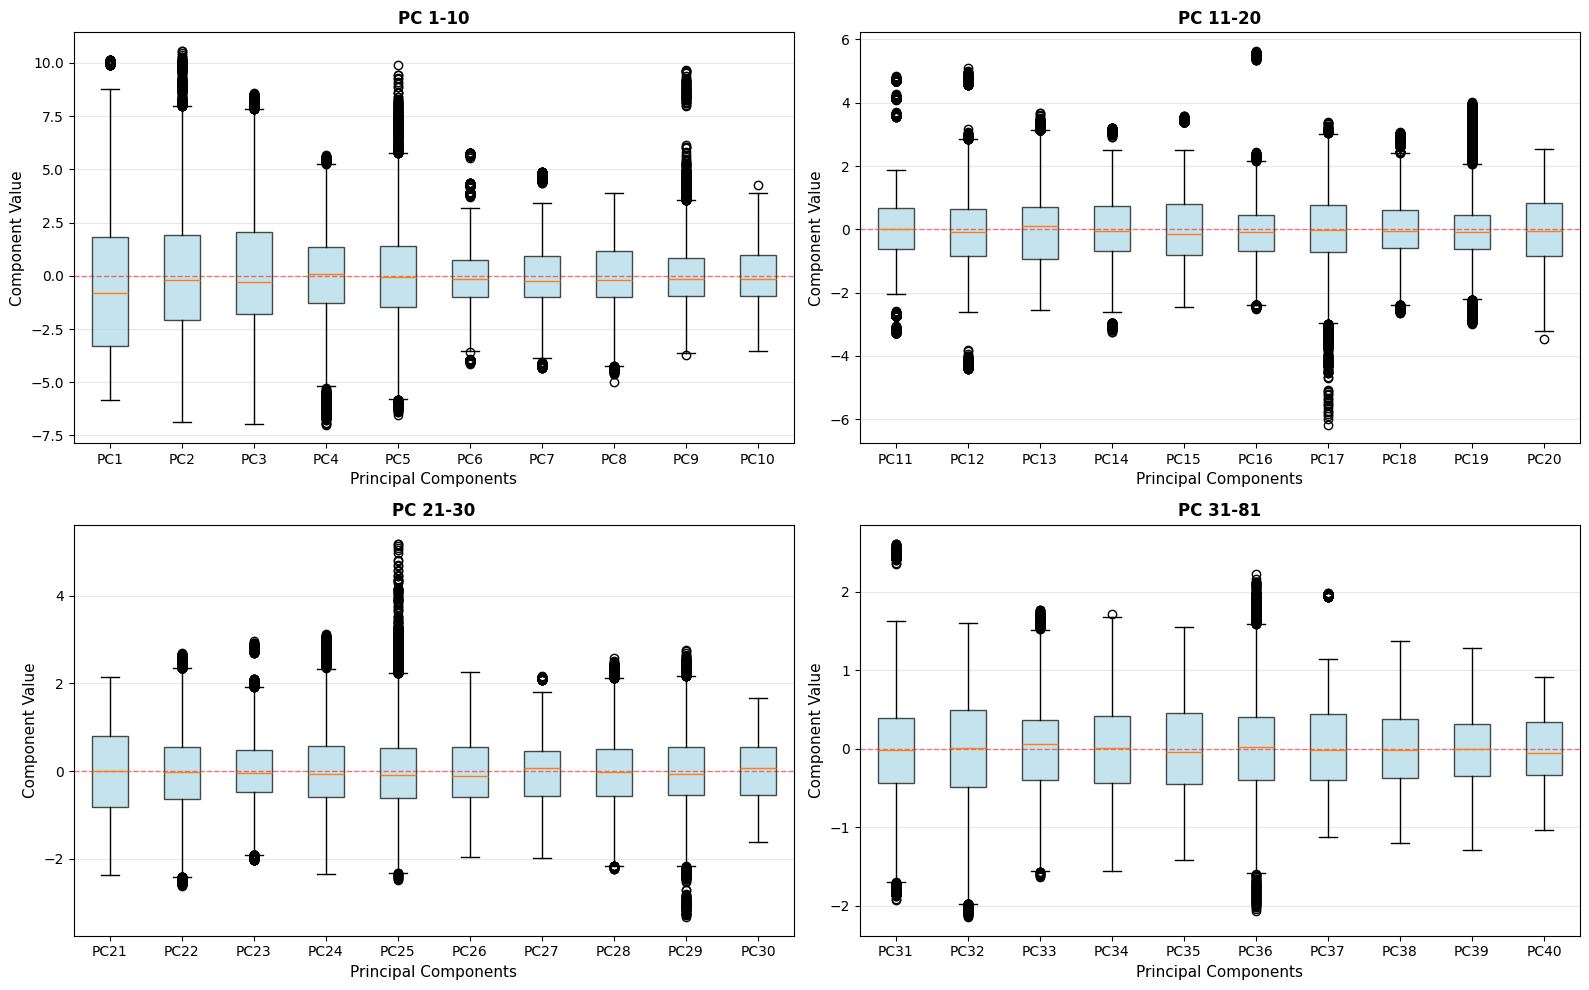

In [15]:
# Create 4 subplots for boxplots of principal components
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

ranges = [(0, 10), (10, 20), (20, 30), (30, min(40, C.shape[1]))]
titles = ['PC 1-10', 'PC 11-20', 'PC 21-30', f'PC 31-{C.shape[1]}']

for idx, (start, end) in enumerate(ranges):
    if start < C.shape[1]:  # Only plot if components exist
        data_to_plot = C[:, start:end]
        bp = axes[idx].boxplot(data_to_plot, patch_artist=True, tick_labels=[f'PC{i+1}' for i in range(start, min(end, C.shape[1]))])
        
        # Color the boxes
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
            patch.set_alpha(0.7)
        
        axes[idx].set_title(titles[idx], fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Component Value', fontsize=11)
        axes[idx].set_xlabel('Principal Components', fontsize=11)
        axes[idx].grid(alpha=0.3, axis='y')
        axes[idx].axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

## 5 - K-Means evaluation (Silhouette & Inertia)

In [16]:
# Evaluate K-Means clustering for different numbers of clusters.
# This cell computes Silhouette scores and inertia values
# to help identify the optimal number of clusters.

K=2, Silhouette: 0.2263, Inertia: 3047100.34
K=3, Silhouette: 0.0923, Inertia: 2854634.05
K=4, Silhouette: 0.0782, Inertia: 2712964.48
K=5, Silhouette: 0.0931, Inertia: 2595069.75
K=6, Silhouette: 0.0941, Inertia: 2488275.04
K=7, Silhouette: 0.1038, Inertia: 2394911.84
K=8, Silhouette: 0.1049, Inertia: 2322401.97
K=9, Silhouette: 0.1092, Inertia: 2248011.20
K=10, Silhouette: 0.1172, Inertia: 2196542.83


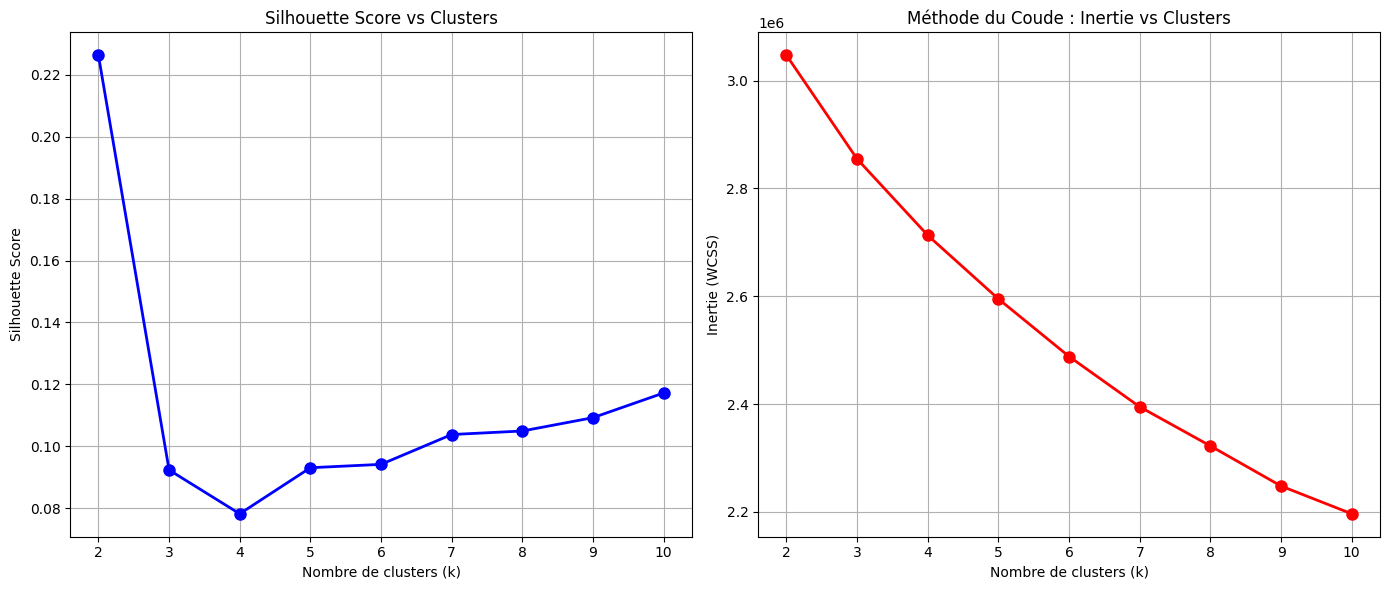

In [17]:

# Initialisation des listes pour stocker les métriques
silhouette_scores = []
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    # Calcul du Silhouette Score (Proximité des clusters)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    
    # Calcul de l'Inertie (Cohésion interne du cluster)
    inertias.append(kmeans.inertia_)
    
    print(f"K={k}, Silhouette: {score:.4f}, Inertia: {kmeans.inertia_:.2f}")

# Création des graphiques comparatifs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 1. Graphique du score de Silhouette (Chercher le maximum)
ax1.plot(K_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Nombre de clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score vs Clusters')
ax1.grid(True)

# 2. Graphique du Coude / Elbow (Chercher la cassure)
ax2.plot(K_range, inertias, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Nombre de clusters (k)')
ax2.set_ylabel('Inertie (WCSS)')
ax2.set_title('Méthode du Coude : Inertie vs Clusters')
ax2.grid(True)

plt.tight_layout()
plt.savefig('clustering_analysis.png')

- The Silhouette score decreases as K increases from 2 to 4, and K=4 shows one of the lowest values in the Silhouette trend.
- Choosing K=4 allows for more granular segmentation of neighborhoods while still keeping clusters relatively distinguishable.
- Even though the Silhouette score is low overall, K=4 provides a balance between having too few clusters (overly broad) and too many clusters (overfitting noise).
- This choice is also practical for visualization and interpretation, especially when mapping clusters across 80 Paris neighborhoods.


## 6 - K-Means Final clustering

In [18]:
# Apply K-Means clustering using the selected optimal number of clusters.
# Cluster labels are assigned to each observation
# and stored for further spatial analysis.


In [19]:
# K mean cluster
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Ajouter la prédiction dans le df
df['cluster'] = clusters

print(f"Clustering completed with k={optimal_k}")
print(f"Cluster distribution:")
print(df['cluster'].value_counts().sort_index())

Clustering completed with k=4
Cluster distribution:
cluster
0     9661
1    15138
2    11724
3     8153
Name: count, dtype: int64


## 7 - K-Means visualization in PCA space

In [20]:
# Visualize K-Means clustering results in the 2D PCA space.
# Cluster centroids are projected and displayed to interpret
# cluster separation and structure.

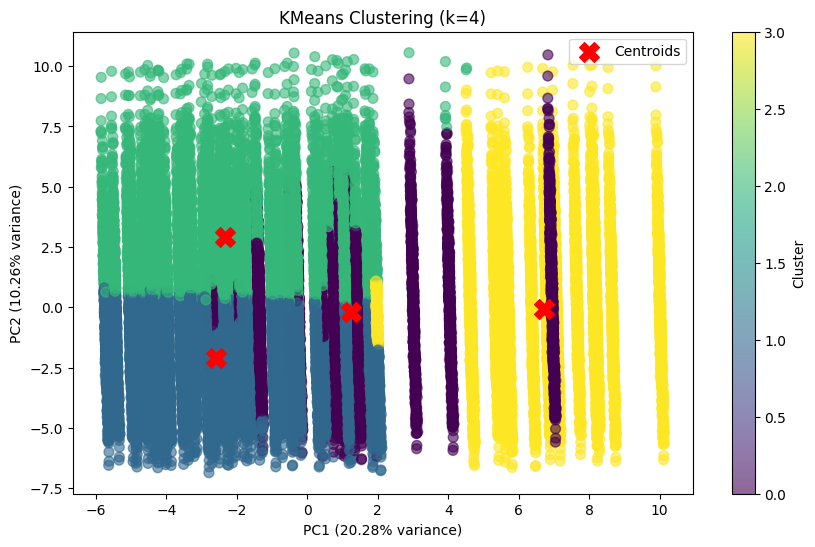

In [21]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.6)
plt.scatter(pca_all.transform(kmeans.cluster_centers_)[:, 0], 
            pca_all.transform(kmeans.cluster_centers_)[:, 1], 
            c='red', marker='X', s=200, label='Centroids')
plt.xlabel(f'PC1 ({pca_all.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_all.explained_variance_ratio_[1]:.2%} variance)')
plt.title(f'KMeans Clustering (k={optimal_k})')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.show()

- The PCA visualization shows four clearly separated clusters, mostly spread along the PC1 axis. This pattern suggests that one variable with strong numerical influence—possibly an ID-like column—may be driving the separation rather than true underlying structure in the data

In [22]:
# Tester avec un quartier
df[df['jointure_nhd_id']==750000012]['cluster'].value_counts()

cluster
1    361
2    251
Name: count, dtype: int64

## 8 - K-Means Aggregation at neighborhood level

In [23]:
# Aggregate clustering results at the neighborhood level.
# Each neighborhood is assigned the most frequent cluster
# among its observations.

In [24]:
# Group by jointure_nhd_id et chercher le cluster le plus apparait
cluster_kmeans = df.groupby('jointure_nhd_id')['cluster'].agg(lambda x: x.value_counts().index[0]).reset_index()
cluster_kmeans.columns = ['jointure_nhd_id', 'kmeans_most_common_cluster']
cluster_kmeans['kmeans_most_common_cluster'] = cluster_kmeans['kmeans_most_common_cluster'].astype('int64')
# df = df.merge(cluster_summary, on='jointure_nhd_id', how='left')


In [25]:
cluster_kmeans['kmeans_most_common_cluster'].value_counts()

kmeans_most_common_cluster
1    41
0    17
3    13
2     2
Name: count, dtype: int64

## 9 - K-Means Spatial visualization

In [26]:
# Merge clustering results with geographic data (GeoJSON)
# and produce maps showing spatial distribution of clusters,
# heat stress indicators, vegetation density and temperature.

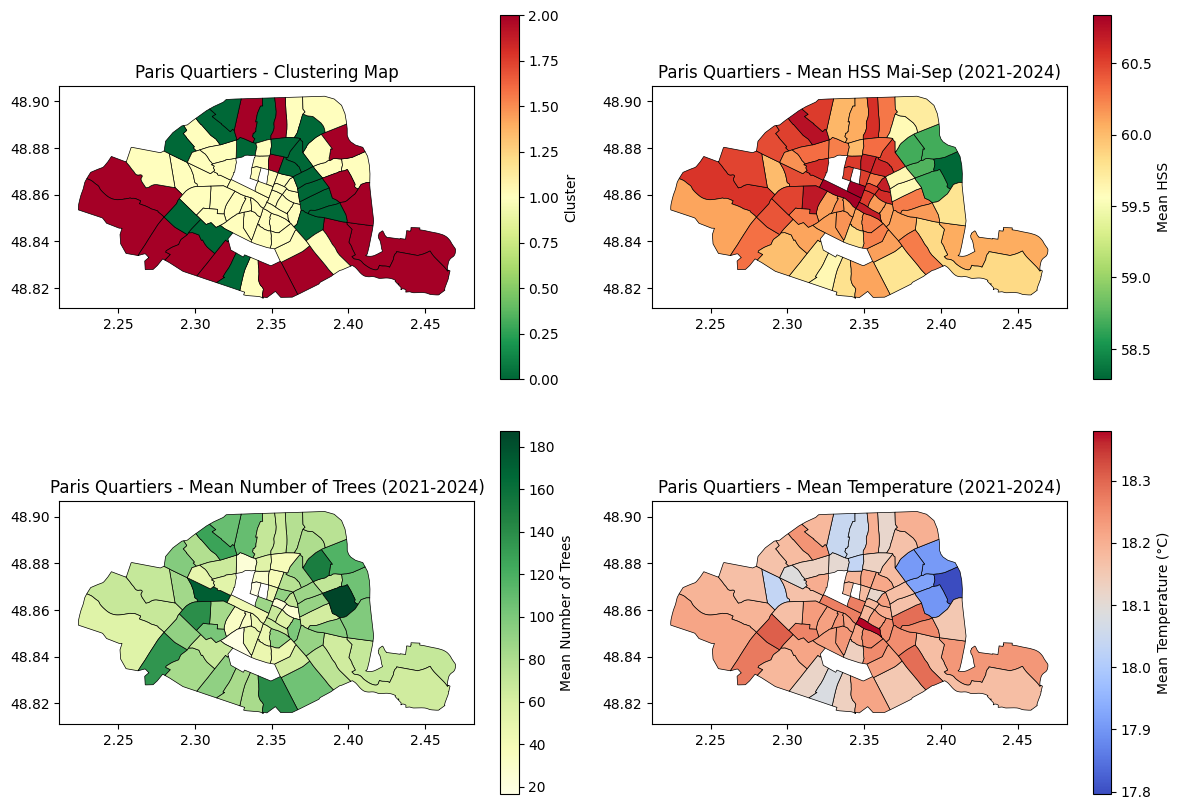

In [ ]:
# display map where we can compare the model clustering result with some datasets variable, find out which variable 
# has more weight on the model

hss_summary = df.groupby('jointure_nhd_id')[['HSS','tree_location_total_density','temp_mean', 'fontain_count' ,'equipment_cooling_equipment']].mean().reset_index()
hss_summary.columns = ['jointure_nhd_id', 'mean_hss', 'mean_trees', 'mean_temp','fontain_count' , 'cooling_equipment_count']

kmeans_gdf = quartiers_geojson.merge(cluster_kmeans, left_on='n_sq_qu', right_on='jointure_nhd_id', how='left')
kmeans_gdf = kmeans_gdf.merge(hss_summary, left_on='n_sq_qu', right_on='jointure_nhd_id', how='left')

# Create the map with discrete colors
fig, ax = plt.subplots(2,2,figsize=(12, 9))
kmeans_gdf.plot(column='kmeans_most_common_cluster', ax=ax[0][0], legend=True, 
         cmap='RdYlGn_r', edgecolor='k', linewidth=0.5,
         legend_kwds={'label': 'Cluster', 'shrink': 0.8},
         vmin=0, vmax=2)
ax[0][0].set_title('Paris Quartiers - Clustering Map')
kmeans_gdf.plot(column='mean_hss', ax=ax[0][1], legend=True, 
         cmap='RdYlGn_r', edgecolor='k', linewidth=0.5,
         legend_kwds={'label': 'Mean HSS', 'shrink': 0.8})
ax[0][1].set_title('Paris Quartiers - Mean HSS Mai-Sep (2021-2024)')
kmeans_gdf.plot(column='mean_trees', ax=ax[1][0], legend=True, 
         cmap='YlGn', edgecolor='k', linewidth=0.5,
         legend_kwds={'label': 'Mean Number of Trees', 'shrink': 0.8})
ax[1][0].set_title('Paris Quartiers - Mean Number of Trees (2021-2024)')
kmeans_gdf.plot(column='mean_temp', ax=ax[1][1], legend=True, 
         cmap='coolwarm', edgecolor='k', linewidth=0.5,
         legend_kwds={'label': 'Mean Temperature (°C)', 'shrink': 0.8})
ax[1][1].set_title('Paris Quartiers - Mean Temperature (2021-2024)')

plt.tight_layout()
plt.show()

## 10 - DBSCAN clustering - alternative model

In [28]:
# Apply DBSCAN clustering to identify density-based patterns.
# This method detects clusters of arbitrary shape and labels noise points.

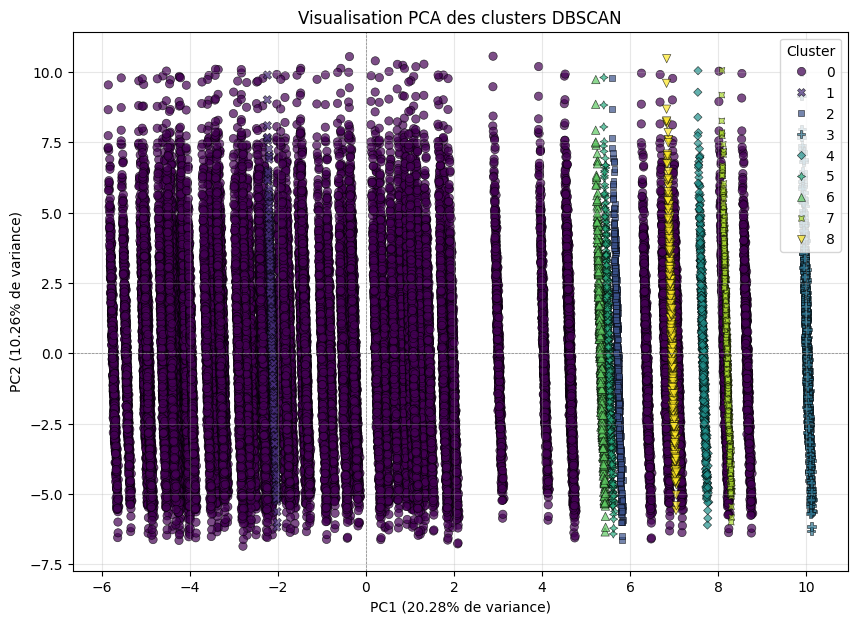

In [29]:
dbscan = DBSCAN(eps=9, min_samples=5)
db_labels = dbscan.fit_predict(X)

# Création d'un DataFrame pour faciliter le plotting avec Seaborn
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = db_labels

# Affichage du graphique
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_pca, 
    x='PC1', y='PC2', 
    hue='Cluster', 
    palette='viridis', 
    style='Cluster',
    legend='full',
    alpha=0.7,
    edgecolor='k'
)

# Ajout du ratio de variance expliquée sur les axes
var_exp = pca_all.explained_variance_ratio_
plt.xlabel(f'PC1 ({var_exp[0]:.2%} de variance)')
plt.ylabel(f'PC2 ({var_exp[1]:.2%} de variance)')
plt.title('Visualisation PCA des clusters DBSCAN')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.show()

- The PCA visualization shows four clearly separated clusters, mostly spread along the PC1 axis. This pattern suggests that one variable with strong numerical influence—possibly an ID-like column—may be driving the separation rather than true underlying structure in the data

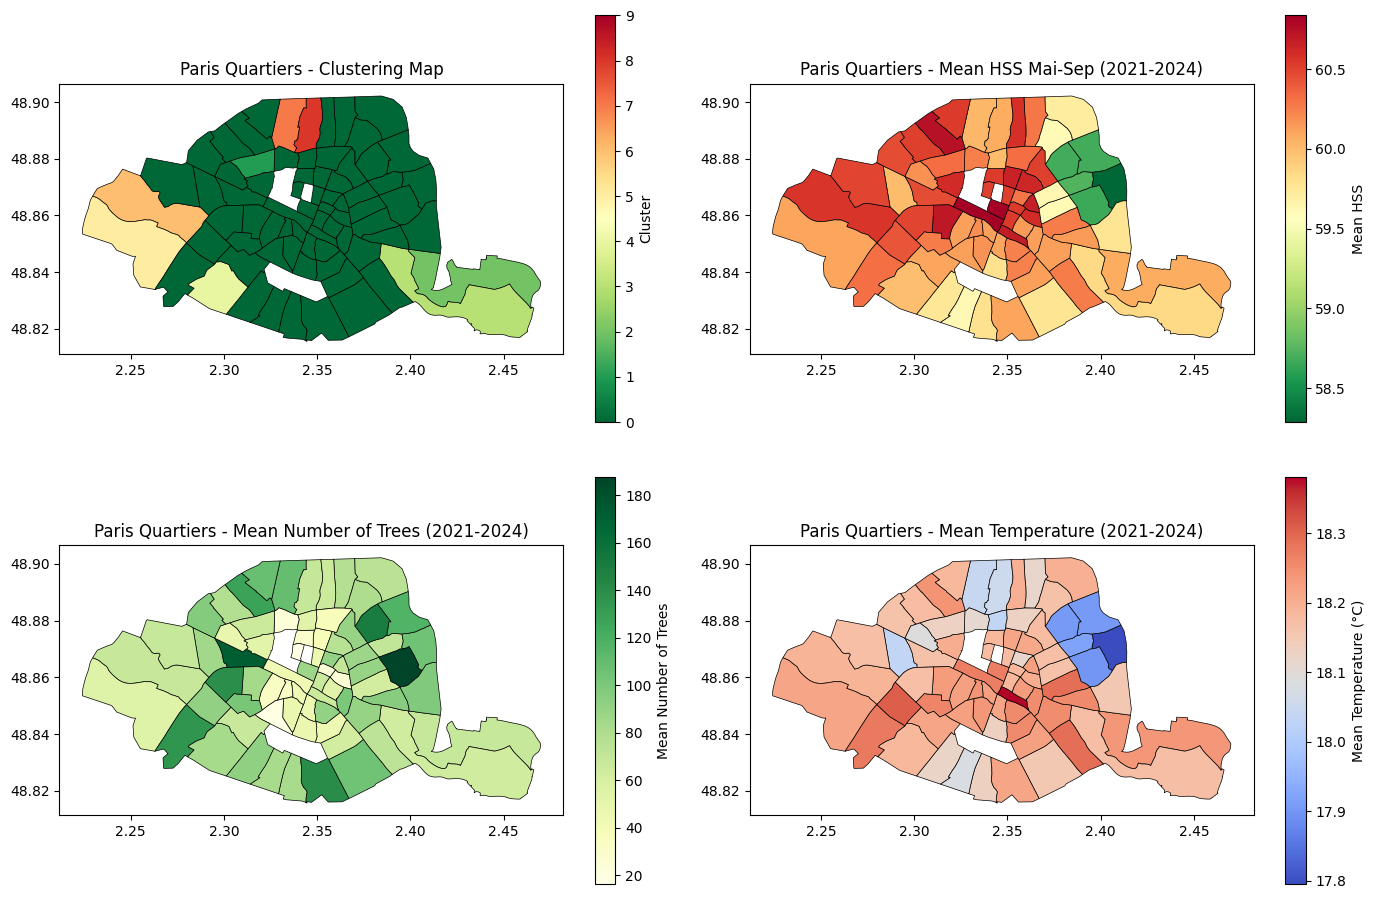

In [ ]:
# display map where we can compare the model clustering result with some datasets variable, find out which variable 
# has more weight on the model
df['cluster'] = db_labels
cluster_dbscan = df.groupby('jointure_nhd_id')['cluster'].agg(lambda x: x.value_counts().index[0]).reset_index()
cluster_dbscan.columns = ['jointure_nhd_id', 'dbscan_most_common_cluster']
cluster_dbscan['dbscan_most_common_cluster'] = cluster_dbscan['dbscan_most_common_cluster'].astype('int64') 

hss_summary = df.groupby('jointure_nhd_id')[['HSS','tree_location_total_density','temp_mean', 'fontain_count' ,'equipment_cooling_equipment']].mean().reset_index()
hss_summary.columns = ['jointure_nhd_id', 'mean_hss', 'mean_trees', 'mean_temp', 'fontain_count' ,'cooling_equipment_count']

dbscan_gdf = quartiers_geojson.merge(cluster_dbscan, left_on='n_sq_qu', right_on='jointure_nhd_id', how='left')
dbscan_gdf = dbscan_gdf.merge(hss_summary, left_on='n_sq_qu', right_on='jointure_nhd_id', how='left')

# Create the map with discrete colors
fig, ax = plt.subplots(2,2,figsize=(14, 10))
dbscan_gdf.plot(column='dbscan_most_common_cluster', ax=ax[0][0], legend=True, 
         cmap='RdYlGn_r', edgecolor='k', linewidth=0.5,
         legend_kwds={'label': 'Cluster', 'shrink': 0.8},
         vmin=0, vmax=9)
ax[0][0].set_title('Paris Quartiers - Clustering Map')
dbscan_gdf.plot(column='mean_hss', ax=ax[0][1], legend=True, 
         cmap='RdYlGn_r', edgecolor='k', linewidth=0.5,
         legend_kwds={'label': 'Mean HSS', 'shrink': 0.8})
ax[0][1].set_title('Paris Quartiers - Mean HSS Mai-Sep (2021-2024)')
dbscan_gdf.plot(column='mean_trees', ax=ax[1][0], legend=True, 
         cmap='YlGn', edgecolor='k', linewidth=0.5,
         legend_kwds={'label': 'Mean Number of Trees', 'shrink': 0.8})
ax[1][0].set_title('Paris Quartiers - Mean Number of Trees (2021-2024)')
dbscan_gdf.plot(column='mean_temp', ax=ax[1][1], legend=True, 
         cmap='coolwarm', edgecolor='k', linewidth=0.5,
         legend_kwds={'label': 'Mean Temperature (°C)', 'shrink': 0.8})
ax[1][1].set_title('Paris Quartiers - Mean Temperature (2021-2024)')

plt.tight_layout()
plt.show()

## 11 - GMM (Gaussian Mixture Model) clustering - alternative model

In [31]:
# Apply Gaussian Mixture Model clustering.
# This probabilistic approach allows soft clustering
# and captures more complex data distributions.

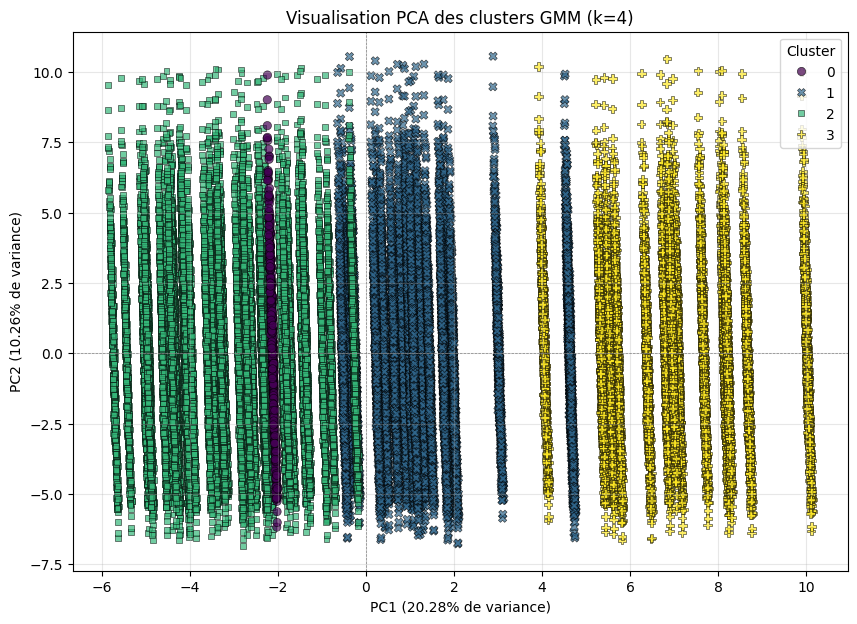

In [32]:
n_clusters = 4 
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(X)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = gmm_labels

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_pca, 
    x='PC1', y='PC2', 
    hue='Cluster', 
    palette='viridis', 
    style='Cluster',
    legend='full',
    alpha=0.7,
    edgecolor='k'
)

var_exp = pca_all.explained_variance_ratio_
plt.xlabel(f'PC1 ({var_exp[0]:.2%} de variance)')
plt.ylabel(f'PC2 ({var_exp[1]:.2%} de variance)')
plt.title(f'Visualisation PCA des clusters GMM (k={n_clusters})')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.show()

- The PCA visualization shows four clearly separated clusters, mostly spread along the PC1 axis. This pattern suggests that one variable with strong numerical influence—possibly an ID-like column—may be driving the separation rather than true underlying structure in the data

## 12 - GMM visualization in PCA space alternative model

In [33]:
# Visualize GMM clustering results in the 2D PCA space
# to assess overlap and separation between probabilistic clusters.
# Aggregate GMM clustering results at the neighborhood level
# and visualize the spatial segmentation of Paris neighborhoods,
# along with climatic and vegetation indicators.

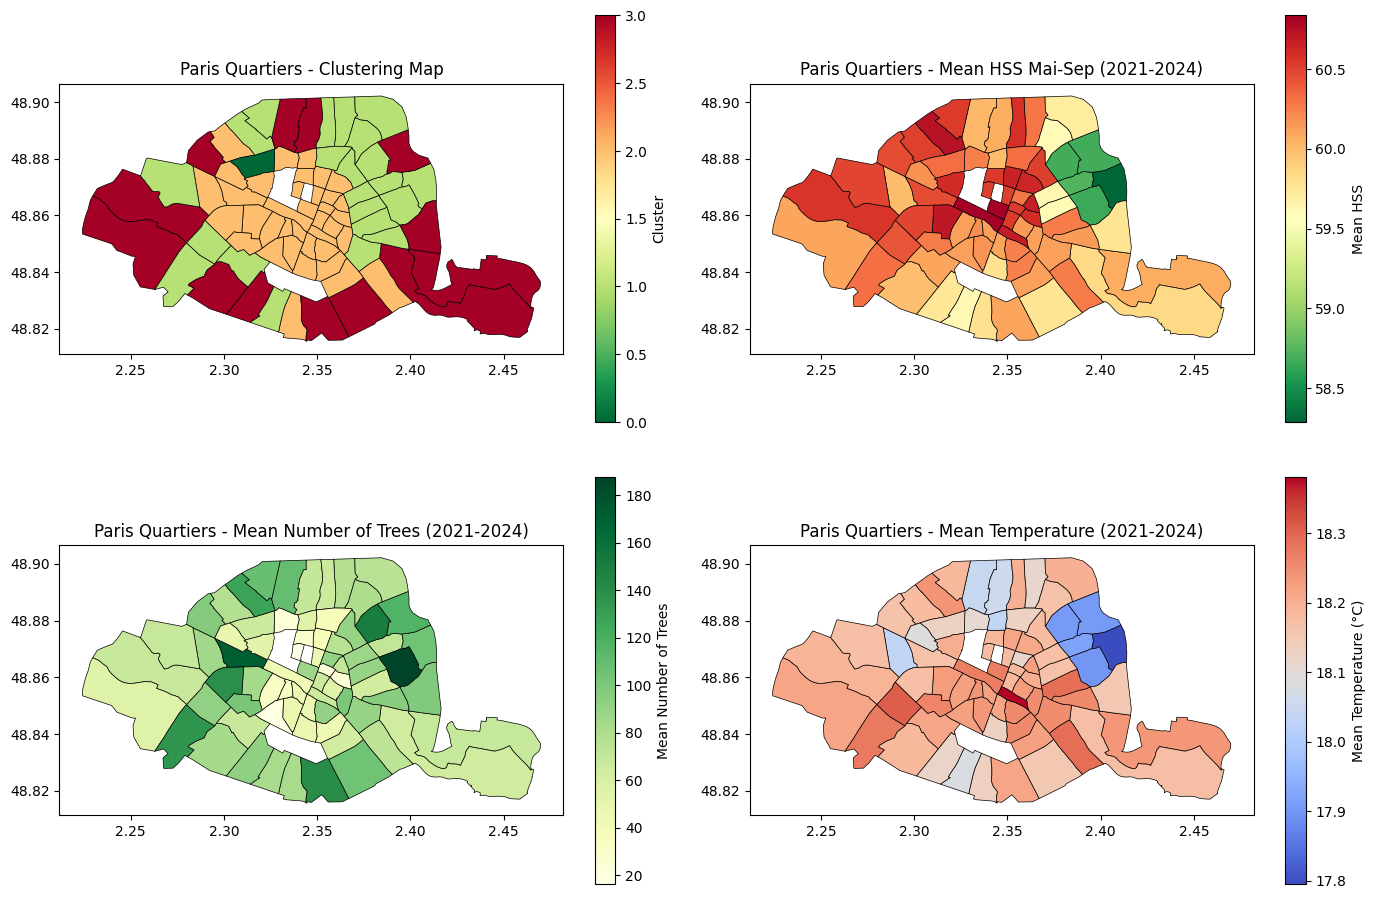

In [ ]:
# display map where we can compare the model clustering result with some datasets variable, find out which variable 
# has more weight on the model

df['cluster'] = gmm_labels
cluster_gmm = df.groupby('jointure_nhd_id')['cluster'].agg(lambda x: x.value_counts().index[0]).reset_index()
cluster_gmm.columns = ['jointure_nhd_id', 'gmm_most_common_cluster']
cluster_gmm['gmm_most_common_cluster'] = cluster_gmm['gmm_most_common_cluster'].astype('int64')

hss_summary = df.groupby('jointure_nhd_id')[['HSS','tree_location_total_density','temp_mean', 'fontain_count' ,'equipment_cooling_equipment']].mean().reset_index()
hss_summary.columns = ['jointure_nhd_id', 'mean_hss', 'mean_trees', 'mean_temp', 'fontain_count' ,'cooling_equipment_count']

gmm_gdf = quartiers_geojson.merge(cluster_gmm, left_on='n_sq_qu', right_on='jointure_nhd_id', how='left')
gmm_gdf = gmm_gdf.merge(hss_summary, left_on='n_sq_qu', right_on='jointure_nhd_id', how='left')

# Create the map with discrete colors
fig, ax = plt.subplots(2,2,figsize=(14, 10))
gmm_gdf.plot(column='gmm_most_common_cluster', ax=ax[0][0], legend=True, 
         cmap='RdYlGn_r', edgecolor='k', linewidth=0.5,
         legend_kwds={'label': 'Cluster', 'shrink': 0.8},
         vmin=0, vmax=3)
ax[0][0].set_title('Paris Quartiers - Clustering Map')
gmm_gdf.plot(column='mean_hss', ax=ax[0][1], legend=True, 
         cmap='RdYlGn_r', edgecolor='k', linewidth=0.5,
         legend_kwds={'label': 'Mean HSS', 'shrink': 0.8})
ax[0][1].set_title('Paris Quartiers - Mean HSS Mai-Sep (2021-2024)')
gmm_gdf.plot(column='mean_trees', ax=ax[1][0], legend=True, 
         cmap='YlGn', edgecolor='k', linewidth=0.5,
         legend_kwds={'label': 'Mean Number of Trees', 'shrink': 0.8})
ax[1][0].set_title('Paris Quartiers - Mean Number of Trees (2021-2024)')
gmm_gdf.plot(column='mean_temp', ax=ax[1][1], legend=True, 
         cmap='coolwarm', edgecolor='k', linewidth=0.5,
         legend_kwds={'label': 'Mean Temperature (°C)', 'shrink': 0.8})
ax[1][1].set_title('Paris Quartiers - Mean Temperature (2021-2024)')

plt.tight_layout()
plt.show()

## 13 - Confirm which model  has Best compromise between interpretability, stability, and spatial coherence.

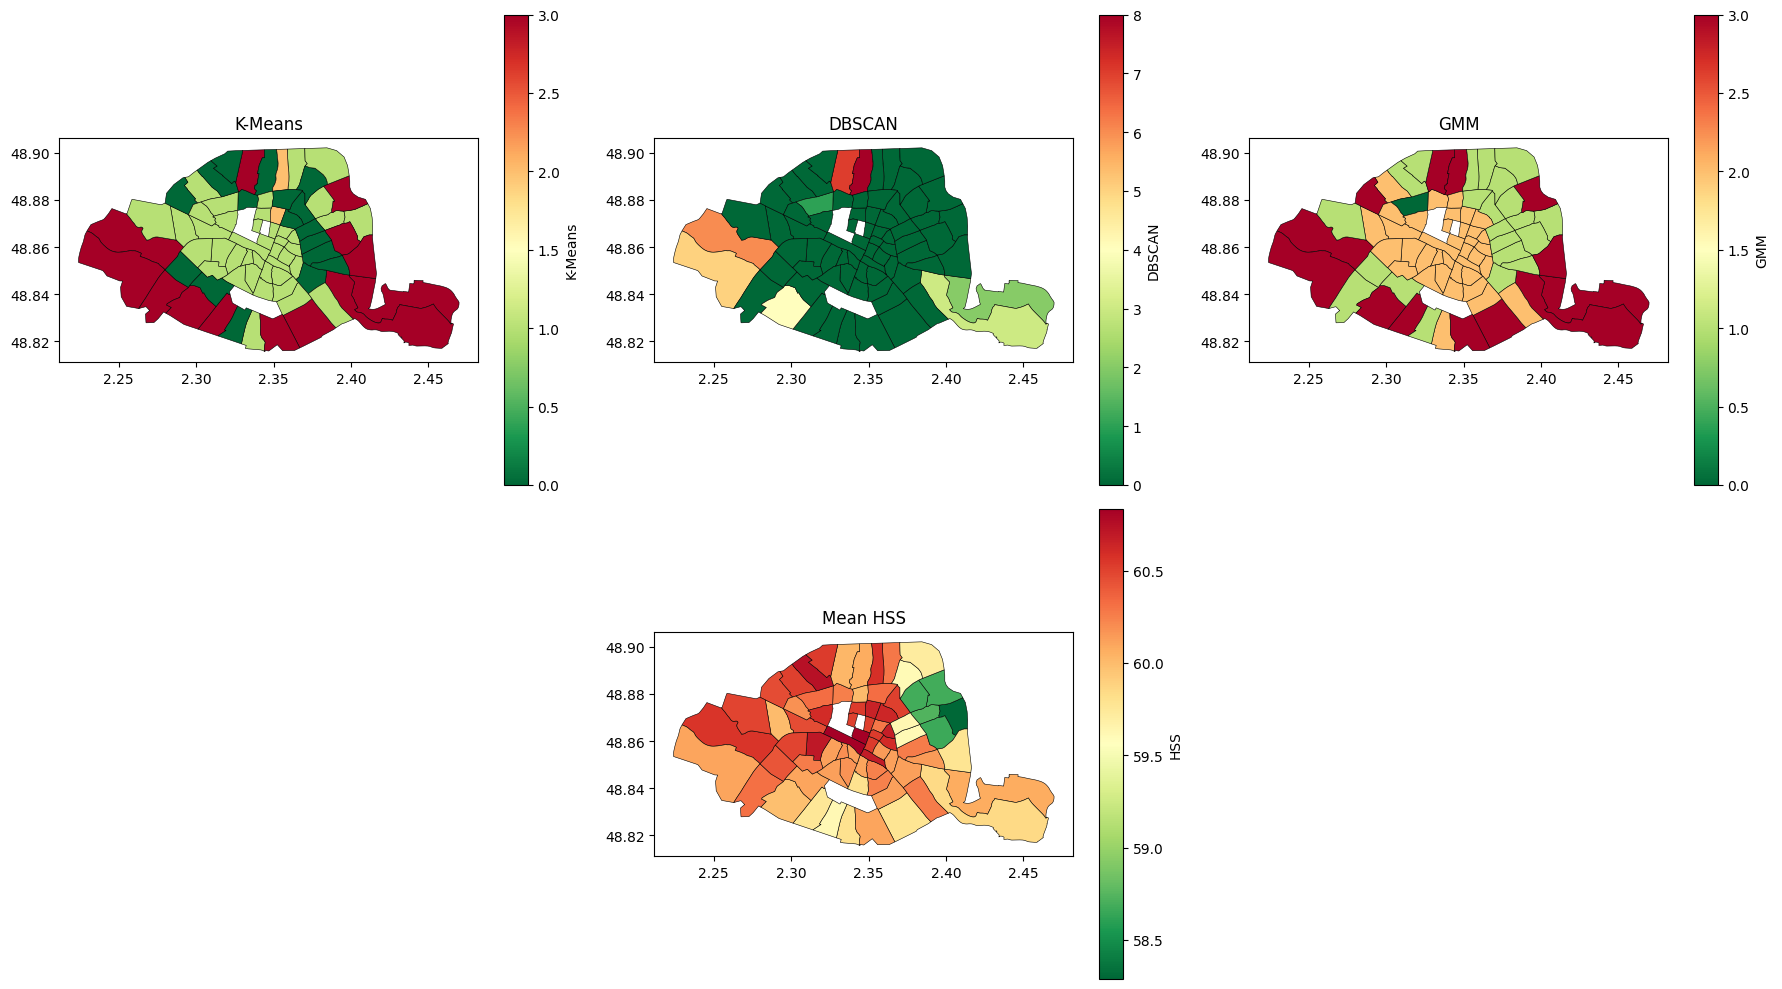

In [35]:

fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# --- ligne 1 ---
kmeans_gdf.plot(column='kmeans_most_common_cluster', ax=ax[0,0], legend=True,
                cmap='RdYlGn_r', edgecolor='k', linewidth=0.4,
                legend_kwds={'label': 'K-Means'})
ax[0,0].set_title('K-Means')

dbscan_gdf.plot(column='dbscan_most_common_cluster', ax=ax[0,1], legend=True,
                cmap='RdYlGn_r', edgecolor='k', linewidth=0.4,
                legend_kwds={'label': 'DBSCAN'})
ax[0,1].set_title('DBSCAN')

gmm_gdf.plot(column='gmm_most_common_cluster', ax=ax[0,2], legend=True,
             cmap='RdYlGn_r', edgecolor='k', linewidth=0.4,
             legend_kwds={'label': 'GMM'})
ax[0,2].set_title('GMM')

# --- ligne 2 : HSS au milieu ---
kmeans_gdf.plot(column='mean_hss', ax=ax[1,1], legend=True,
                cmap='RdYlGn_r', edgecolor='k', linewidth=0.4,
                legend_kwds={'label': 'HSS'})
ax[1,1].set_title('Mean HSS')

# Cases vides
ax[1,0].set_axis_off()
ax[1,2].set_axis_off()

plt.tight_layout()
plt.show()


- The comparison between the three clustering methods shows that the spatial organization of the clusters is strongly driven by the distribution of the HSS values. Areas with similar HSS levels tend to be grouped together regardless of the method, which indicates that HSS is one of the dominant variables shaping the clustering structure. However, among the three approaches, K‑Means provides the most coherent alignment with the spatial gradient of the mean HSS: districts with higher or lower HSS values are grouped in a more consistent and homogeneous way. In contrast, DBSCAN introduces irregular clusters due to its sensitivity to density variations, and GMM produces overlapping regions that follow the HSS pattern less clearly. Overall, K‑Means appears to be the method that best captures the underlying structure of the HSS distribution across the city.

In [37]:
# display cluster by cluster in order to have a global overview 

# column to group by
cluster_col = 'kmeans_most_common_cluster'

# Per-cluster summary (one row per cluster)
summary_by_cluster = (
    kmeans_gdf.groupby(cluster_col)
       .agg(
           n_quarters = ('n_sq_qu', 'count'),
           hss_mean   = ('mean_hss', 'mean'),
           hss_min    = ('mean_hss', 'min'),
           hss_max    = ('mean_hss', 'max'),
           trees_mean = ('mean_trees', 'mean'),
           temp_mean  = ('mean_temp', 'mean'),
           n_fontain  = ('fontain_count', 'count'),
           n_cooling_eq  = ('cooling_equipment_count', 'count')
       )
       .reset_index()
       .sort_values(cluster_col)
)

summary_by_cluster


,kmeans_most_common_cluster,n_quarters,hss_mean,hss_min,hss_max,trees_mean,temp_mean,n_fontain,n_cooling_eq
0,0.0,17,60.180216,59.605251,60.744694,80.847059,18.187075,17,17
1,1.0,41,60.192037,58.287797,60.836158,67.472195,18.173755,41,41
2,2.0,2,60.617105,60.581955,60.652255,52.115000,18.207803,2,2
3,3.0,13,59.819319,58.656243,60.558845,101.851538,18.136389,13,13


- Although the maps initially suggested a visual alignment with HSS, the cluster‑level summary indicates that HSS and temperature are nearly constant across clusters, while tree density varies the most. This means K‑Means is primarily segmenting districts by vegetation rather than HSS. We therefore revise our conclusion: K‑Means produces the most interpretable segmentation here, but it is driven by tree density, and very small clusters (e.g., n=2) should be treated with caution.”

-------

### Note: see the Methodological Note for further explanations on limitations and potential improvements.